In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns; sns.set()

import scipy.stats as sts 
from sklearn.neighbors import LocalOutlierFactor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm, cv

## Data exploration 

Дано: 
- Длительность теста: 1 неделя 
- TG получили скидки разной глубины: treatment = {20%, 25%, 30%}
- CG - ничего, treatment={control}  

*Данные*  
Датасет состоит из транзакционных признаков
- sum_orders - кол-во заказов клиента
- sum_cnt_product - кол-во заказанных продуктов
- treatment - размер скидки или ее отсутствие
- sum_revenue - выручка клиента
- sum_fm - прибыль с клиента (маржинальность) 
- таргеты по результатам акции (колонки с префиксом target_)
- visit - отклик за период акции (совершил / не совершил заказ)


# Загрузка данных, ознакомление 

In [2]:
data = pd.read_csv('Downloads/sample.csv')

In [3]:
def show(df, n_rows=3): 
    display(df.head(n_rows))
    print('Full shape: ', df.shape)

In [4]:
display(data.info()) 
show(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321953 entries, 0 to 321952
Columns: 242 entries, treatment to target_7_visit
dtypes: float64(181), int64(60), object(1)
memory usage: 594.4+ MB


None

treatment  last_sap  nuniq_sap  last_dt  lifetime  cnt_weekend  cnt_orders  \
0   p25_999       283          2       60      1674            2           6   
1   p20_999       573          1       86      1672            3           4   
2   p20_999       233          1      131      1670            1           1   

   cnt_nuniq_products  cnt_products  cnt_nuniq_category  ...  \
0                  12            23                   5  ...   
1                  11            17                   5  ...   
2                   1             1                   1  ...   

   roll_60days_14probs  roll_90days_14probs  roll_120days_14probs  \
0                  0.0                  0.0                   0.0   
1                  0.0                  0.0                   0.0   
2                  0.0                  0.0                   0.0   

   roll_160days_14probs  roll_300days_14probs  target_7_sum_revenue  \
0                   0.0                   0.0                 918.0   
1                   0.0                   0.0                   0.0   
2                   0.0                   0.0                   0.0   

   target_7_sum_orders  target_7_sum_fm  target_7_sum_cnt_product  \
0                    1       575.649868                         3   
1                    0         0.000000                         0   
2                    0         0.000000                         0   

   target_7_visit  
0               1  
1               0  
2               0  

[3 rows x 242 columns]

Full shape:  (321953, 242)


In [5]:
#data.columns.values 

In [6]:
target_cols = [col for col in data.columns if 'target_' in col] 
target_titles = dict(zip(target_cols, ['Выручка', 'Количество заказов', 'Прибыль', 'Количество продуктов', 'Отклик']))
target_titles                   

{'target_7_sum_revenue': 'Выручка',
 'target_7_sum_orders': 'Количество заказов',
 'target_7_sum_fm': 'Прибыль',
 'target_7_sum_cnt_product': 'Количество продуктов',
 'target_7_visit': 'Отклик'}

In [7]:
data.isna().sum().sum(), data.duplicated().sum()

(0, 0)

In [8]:
# for readability 
data['group'] = np.where(data['treatment']=='control', 'CG', 'TG') 
data['treatment_flg'] = np.where(data['treatment']=='control', 0, 1) 

In [9]:
data['group'].value_counts(), 32433/289520

(TG    289520
 CG     32433
 Name: group, dtype: int64,
 0.1120233489914341)

In [10]:
data['treatment'].value_counts()

p25_999    96586
p20_999    96532
p30_999    96402
control    32433
Name: treatment, dtype: int64

# Расчет ATE, выбор таргета 
Методология расчетов ATE взята [отсюда](https://www.causalflows.com/estimating-average-treatment-effects/) (см. "How Can We Deal With Bias In An ATE Estimation"). 

> While randomizing treatment enables the SDO to be an unbiased estimate of ATE, in order to minimize the variance of the estimate practitioners must also ensure they are calculating an SDO from a sufficiently large sample population. 

Делаем assumption, что пользователи для групп выбирались случайно, размеры выборок достаточно велики. 

### Проблемы данных 
1. Неодинаковые размеры тестовой и контрольной группы, контрольная группа в ~10 раз меньше, чем тестовая. 
2. Наличие в тестовой группе разных вариантов скидок. Это нарушает [SUTVA](https://bookdown.org/paul/applied-causal-analysis/sutva1.html) (см. п. 2) 

### Потенциальные решения 
1. Применить бутстреп, чтобы повысить confidence в оценке. 
2. Рассматривать пользователей с разными размерами скидок как отдельные тестовые группы. 

In [11]:
grouper = data.groupby('group')
grouper_det = data.groupby('treatment')

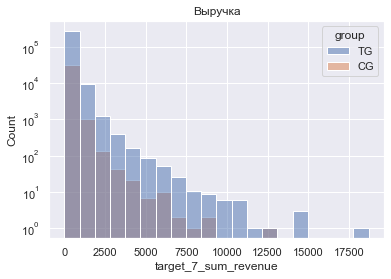

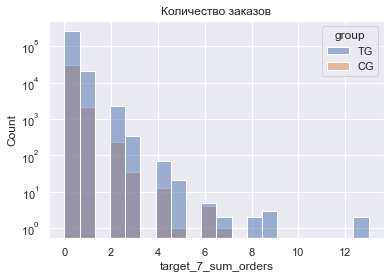

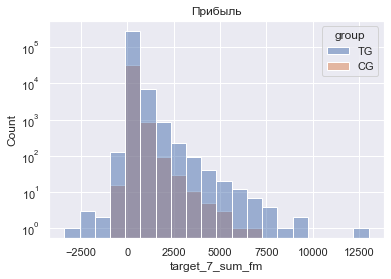

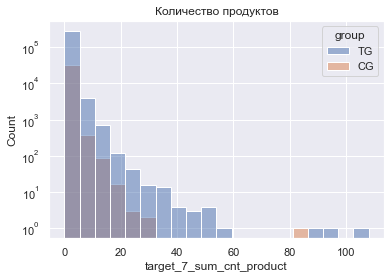

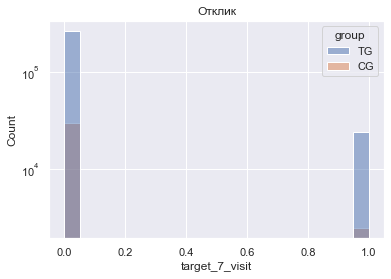

In [12]:
# Q&D hists 
# bins in sns are not always good 
for t in target_cols: 
    sns.histplot(data=data, x=t, hue='group')
    plt.yscale("log")  
    plt.title(target_titles[t]); plt.show()

In [13]:
# no split on discounts 
for target in target_cols:
    tmp = grouper[target].mean().rename(target_titles[target])
    display(tmp)
    display(f'ATE: {tmp.diff(periods=1).loc["TG"]:.4f}')
    print(' ')

group
CG    83.333580
TG    88.475573
Name: Выручка, dtype: float64

'ATE: 5.1420'

group
CG    0.087904
TG    0.094287
Name: Количество заказов, dtype: float64

'ATE: 0.0064'

group
CG    54.605275
TG    56.911292
Name: Прибыль, dtype: float64

'ATE: 2.3060'

group
CG    0.311072
TG    0.340008
Name: Количество продуктов, dtype: float64

'ATE: 0.0289'

group
CG    0.076188
TG    0.082841
Name: Отклик, dtype: float64

'ATE: 0.0067'

In [14]:
# with split on discounts 
for target in target_cols:
    tmp = grouper_det[target].mean().rename(target_titles[target])
    cg = tmp['control']
    ate = tmp - cg
    
    print(f'----mean {target} for groups---')
    display(tmp)
    print('-----ATE for target groups----')
    display(ate.iloc[1:])
    print(' ')

----mean target_7_sum_revenue for groups---


treatment
control    83.333580
p20_999    86.642046
p25_999    87.641190
p30_999    91.147549
Name: Выручка, dtype: float64

-----ATE for target groups----


treatment
p20_999    3.308466
p25_999    4.307610
p30_999    7.813969
Name: Выручка, dtype: float64

 
----mean target_7_sum_orders for groups---


treatment
control    0.087904
p20_999    0.091110
p25_999    0.093606
p30_999    0.098151
Name: Количество заказов, dtype: float64

-----ATE for target groups----


treatment
p20_999    0.003205
p25_999    0.005701
p30_999    0.010247
Name: Количество заказов, dtype: float64

 
----mean target_7_sum_fm for groups---


treatment
control    54.605275
p20_999    56.406658
p25_999    56.233882
p30_999    58.095308
Name: Прибыль, dtype: float64

-----ATE for target groups----


treatment
p20_999    1.801383
p25_999    1.628607
p30_999    3.490033
Name: Прибыль, dtype: float64

 
----mean target_7_sum_cnt_product for groups---


treatment
control    0.311072
p20_999    0.327570
p25_999    0.337378
p30_999    0.355096
Name: Количество продуктов, dtype: float64

-----ATE for target groups----


treatment
p20_999    0.016498
p25_999    0.026306
p30_999    0.044024
Name: Количество продуктов, dtype: float64

 
----mean target_7_visit for groups---


treatment
control    0.076188
p20_999    0.080388
p25_999    0.081958
p30_999    0.086181
Name: Отклик, dtype: float64

-----ATE for target groups----


treatment
p20_999    0.004200
p25_999    0.005770
p30_999    0.009993
Name: Отклик, dtype: float64

Видим, что присутствуют значительные отличия в средних и АТЕ между разными скидочными группами. Чем больше скидка, тем лучше заметен эффект от кампании. 
В целом, кампания прошла успешно, метрики повысились относительно КГ.  

Для проверки стат.значимости можно дополнительно применить бутстреп/подобрать стат.тест для интересующих метрик. 

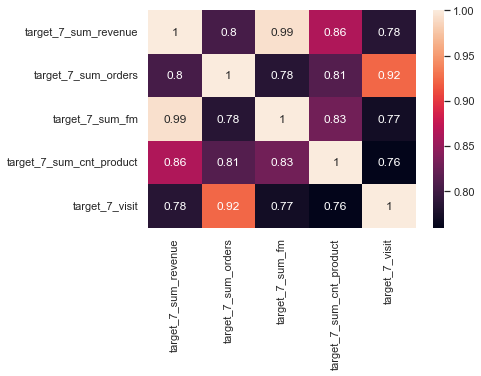

In [15]:
sns.heatmap(data[target_cols].corr(), annot=True); plt.show()

### Выбор таргета 
- Ожидаемо, очень высокая корреляция между маржой и выручкой, из этих двух признаков имеет смысл предсказывать выручку, т.к. маржинальность является производным параметром. 
- Достаточно высокая корреляция между количеством заказов и фактом отклика. Данная оценка бессмысленна, т.к. отклик - бинарный параметр. Однако, подтверждает то, что мы уже видели на гистограмме target_7_sum_orders - подавляющее большинство делает один заказ за агрегируемый период времени. 

Наиболее широко распространенный подход к uplift-моделированию - прогнозирование вероятностей отклика и выручек при наличии коммуникации и ее отсутствии (личный опыт + литература). Также видим достаточно высокие корреляции других таргетов с ними, поэтому дальнейший выбор будет производиться между этими признаками. 

С помощью бутстрепа смоделируем распределения средних для этих двух признаков для КГ и ЦГ, чтобы оценить, есть ли стат. значимые отличия между результатами КГ и ЦГ. 

In [16]:
def bootstrap_mean(series, n_iter=10000): 
    n_samples = int(series.shape[0]*0.8)
    bootstrapped_dist = np.fromiter(
        (series.sample(n_samples).mean() for i in range(n_iter)), 
        float, 
        -1
    )
    return pd.Series(bootstrapped_dist)

In [17]:
tmp=[target_cols[0], target_cols[-1]]
bootstrap_results = {}
for g in ['TG', 'CG']: 
    bootstrap_results[g] = data.query(f'group == "{g}"')[tmp].apply(lambda x: bootstrap_mean(x))

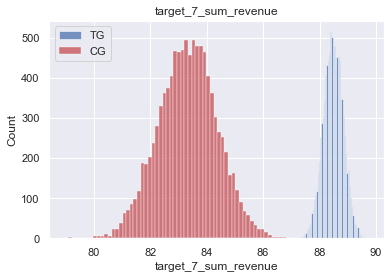

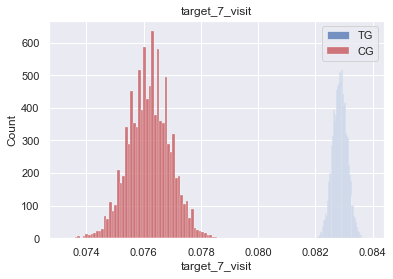

In [18]:
for col in tmp: 
    sns.histplot(bootstrap_results['TG'][col], label='TG')#.hist(bins=100)
    sns.histplot(bootstrap_results['CG'][col], color='r', label='CG')#.hist(bins=100)
    plt.legend(); plt.title(col); plt.show()

Наблюдаем, что есть стат. значимые различия между полученными средними значениями метрик (95% CI распределений не пересекаются). 
Специфика бизнеса подразумевает, что продукт покупается сопоставимо часто и без продвижения - мы видим малую разницу конверсий между ЦГ и КГ (около 1%). Предсказанный по конверсии uplift, вероятно, тоже будет очень мал. 

В таком случае логично предсказывать выручку. На бутстреп-распределениях наблюдаем эффект ~ 6 рублям.  

Такие низкие эффекты связаны с природой данных - таргеты очень sparsed. Видимо, охват клиентской базы велик, но в целом "постоянных покупателей" немного. К тому же, длительность МК составляет всего лишь неделю - это не слишком большой срок. 

Низкие эффекты потенциально могут затруднять последующее моделирование.  

Таргет - target_7_sum_revenue. 


In [19]:
# only visited 
# cannibalisation? 
display(data[data['target_7_visit']==1].groupby(['group'])['target_7_sum_revenue'].mean()) 
display(data[data['target_7_visit']==1].groupby(['group'])['target_7_sum_fm'].mean()) 

group
CG    1093.791178
TG    1068.022348
Name: target_7_sum_revenue, dtype: float64

group
CG    716.719098
TG    686.997881
Name: target_7_sum_fm, dtype: float64

# EDA, выбор признаков 

# Наличие выбросов в выбранных параметрах 

Было испробовано несколько алгоритмов детекции аномалий, отработавших неуспешно, т.к. они требуют подбора входных параметорв (~количество соседей), для которых необходимо более тщательное исследование данных. Дополнительно осложняет отбор то, что данные sparsed. 

В таком случае стабильнее сработает метод "подрезки" данных по какому-либо перцентилю. Были опробованы подходы: 
1) Принцип boxplot - будем считать выбросами все, что лежит за пределами 1,5Q - неадекватный результат. Во многих случаях 75-й перцентиль оказался равен нулю, таким образом были отброшены самые полезные данные. 
2) Поднятие границы перцентиля до 97-99. В таком случае отсекалось слишком много данных, при этом не было уверенности в том, что они являлись выбросами на самом деле (подход опасен для "узких" распределений). 

В результате обработка выбросов ограничилась отсечением объектов с отрицательными значениями. 

Оценим количество негативных данных в выбранных признаках. 

Также, мы уже знаем, что: 
1. В данных нет nan 
2. В данных нет полных дубликатов 

In [20]:
# drop added features 
features = data.drop(columns=target_cols+['treatment_flg', 'group']).copy()
features.shape

(321953, 237)

In [21]:
# select numeric  
# all data but 'treatment' features is numeric 
num = features.select_dtypes(include=[np.number])
num.shape

(321953, 236)

In [22]:
set(features.columns) - set(num.columns)

{'treatment'}

In [23]:
neg = (num < 0).mean() 
neg[neg > 0]

fm                               0.009952
avg_fm                           0.009952
all_discount                     0.000348
avg_discount                     0.000348
sum_trip                         0.000668
avg_trip                         0.000668
roll_7_sum_discount_mov          0.000680
roll_14_sum_discount_mov         0.000655
roll_21_sum_discount_mov         0.000652
roll_30_sum_discount_mov         0.000631
roll_45_sum_discount_mov         0.000572
roll_60_sum_discount_mov         0.000534
roll_90_sum_discount_mov         0.000488
roll_120_sum_discount_mov        0.000426
roll_160_sum_discount_mov        0.000401
roll_300_sum_discount_mov        0.000348
roll_30_60_sum_discount_mov      0.000115
roll_60_90_sum_discount_mov      0.000084
roll_90_120_sum_discount_mov     0.000053
roll_120_160_sum_discount_mov    0.000096
roll_160_300_sum_discount_mov    0.000065
Balance                          0.000006
dtype: float64

In [24]:
# Removing the outliers, 1.5Q
def count_outliers_itq(series):
    q3 = np.quantile(series, 0.75)
    q1 = np.quantile(series, 0.25)
    iqr = q3 - q1
    
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    
    otl_cond = (series>upper) | (series<lower)
    otl_amount = (otl_cond).sum()
    return otl_amount/series.shape[0]

In [25]:
otl = num.apply(count_outliers_itq).sort_values(ascending=False)
otl.head(3)

roll_160_300_sum_discount_mov    0.242737
roll_14_sum_orders               0.235522
roll_30_60_sum_discount_mov      0.223368
dtype: float64

0.0


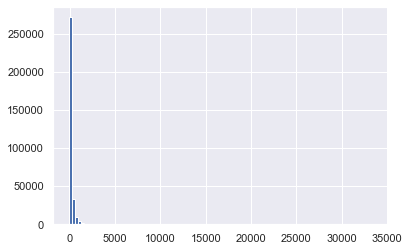

In [26]:
# 75% of data are equal to 0, that's why we get all non-zero data as outliers 
tmp = num['roll_30_60_sum_discount_mov']
print(tmp.quantile(.75)) 
tmp.hist(bins=100); plt.show()

Из-за подобных артефактов (см. ячейку выше) алгоритм отбора признаков неадекватен. Попытаемся задать верхнюю границу вручную, установив ее на значение 98-го перцентиля. 
Нижнюю границу пока проигнорируем, т.к. большинство исследованных распределений начинается в 0 и тянется вправо. 

In [27]:
def count_otl_manual(series): 
    q99 = series.quantile(.99)
    return (series>q99).sum()/series.shape[0]

In [28]:
otl = num.apply(count_otl_manual).sort_values(ascending=False)

In [29]:
display(otl.head(3));

sum_shelf                      0.010001
roll_160_max_median_rto_mov    0.010001
sum_trip                       0.010001
dtype: float64

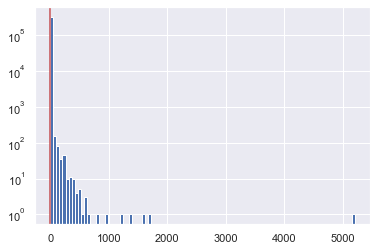

In [30]:
num['roll_160_300_sum_redemption'].hist(bins=100, log=True) 
plt.axvline(num['roll_160_300_sum_redemption'].quantile(.99), color='r'); plt.show()

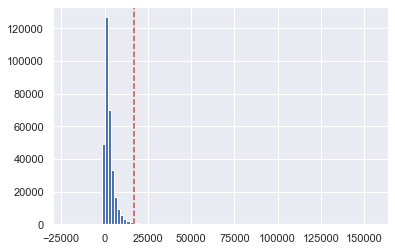

In [31]:
# definitely negative outliers + huge value after 99th (~150k)
num['sum_trip'].hist(bins=100) 
plt.axvline(num['sum_trip'].quantile(.99), color='r', linestyle='--'); plt.show()

In [32]:
# at least one negative value in a row
mask = num.lt(0).any(axis=1)
print(f'Dropped: {mask.sum()/num.shape[0]:.2%}') 
num = num[~mask]

Dropped: 1.18%


In [33]:
def mask_otl(series): 
    q99 = series.quantile(.99)
    return (series>q99)
print(f'Dropped data in case of outliers filtering: {(num.apply(mask_otl).any(axis=1)).sum() / num.shape[0]:.2%}')

Dropped data in case of outliers filtering: 33.72%


На данном этапе ограничимся отсечением негативных данных, т.к. они 
1) малочисленны, даже если не являются багами 
2) скорее всего являются багами 

Отбрасывание всех данных, помеченных как выбросы, приведет к потере почти 30% данных - это нерационально, т.к. 
1) мы не можем достоверно отделить True positives, поэтому рискуем потерять хорошие данные 
2) в теории, модели, которые мы планируем использовать, должны быть устойчивы к выбросам


Также можем наблюдать признаки, где почти все, либо все признаки == 0.  

Признак с большим количеством нулей не обязательно неинформативен для модели, он может быть несбалансирован.  
Наверняка неинформативными признаками можно считать те, в которых все или почти все объекты имеют значение 0. 

In [34]:
empty_frac = (num == 0).mean()
empty_frac[empty_frac>=.97]

std_rto_mov                    0.974529
roll_60_90_sum_usage_mov       0.976534
roll_90_120_sum_usage_mov      0.981202
roll_120_160_sum_usage_mov     0.987378
roll_160_300_sum_usage_mov     0.994314
roll_30_60_sum_redemption      0.972775
roll_60_90_sum_redemption      0.981428
roll_90_120_sum_redemption     0.988009
roll_120_160_sum_redemption    0.993513
roll_160_300_sum_redemption    0.998847
roll_30_60_max_redemption      0.972775
roll_60_90_max_redemption      0.981428
roll_90_120_max_redemption     0.988009
roll_120_160_max_redemption    0.993513
roll_160_300_max_redemption    0.998847
roll_30_60_avg_redemption      0.972775
roll_60_90_avg_redemption      0.981428
roll_90_120_avg_redemption     0.988009
roll_120_160_avg_redemption    0.993513
roll_160_300_avg_redemption    0.998847
roll_0_30days_14probs          1.000000
roll_30_60days_14probs         1.000000
roll_60_90days_14probs         1.000000
roll_90_120days_14probs        1.000000
roll_120_160days_14probs       1.000000


## Feature selection 

In [35]:
# drop target + empty features 
features = data.drop(columns=target_cols + list(empty_frac[empty_frac>=.97].index))
f'Features amount - {features.shape}' 

'Features amount - (321953, 207)'

В датасете видим большое количество признаков, ручной отбор без наличия документации к данным займет очень много времени. 
Наилучшая стратегия в таком случае - выбрать потенциально лучшие признаки автоматически.  

В условиях реального рабочего процесса смысл большинства параметров будет понятен, поэтому вслепую накатывать feature selection, конечно, не придется. Будет возможно лучше подобрать методы выделения признаков, либо отсеить ненужные признаки самостоятельно. 

Изначально feature selection планировалось проводить тремя способами: 
* Метод feature_importances_ случайного леса 
* Permutation importance, [Sklearn docs](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)
* [Catboost.select_features](https://catboost.ai/en/docs/concepts/python-reference_catboost_select_features)

Однако, в силу низкого качества полученной модели RandomForest, результаты отбора признаков с ее использованием нельзя считать адекватными. 

Catboost позволяет оценить, как меняется loss в зависимости от количества удаленных признаков. Совершим две итерации: 
- Удалим все признаки, кроме одного. Это позволит увидеть динамику loss полностью. Определим точку, в которой начинается явное возрастание потерь. 
- Удалим количество признаков, определенное на этапе 1. 

Кроме того, по личному опыту Catboost является лучшим вариантом модели "из коробки" - выбор фичей с его использованием может повысить качество будущей модели. 

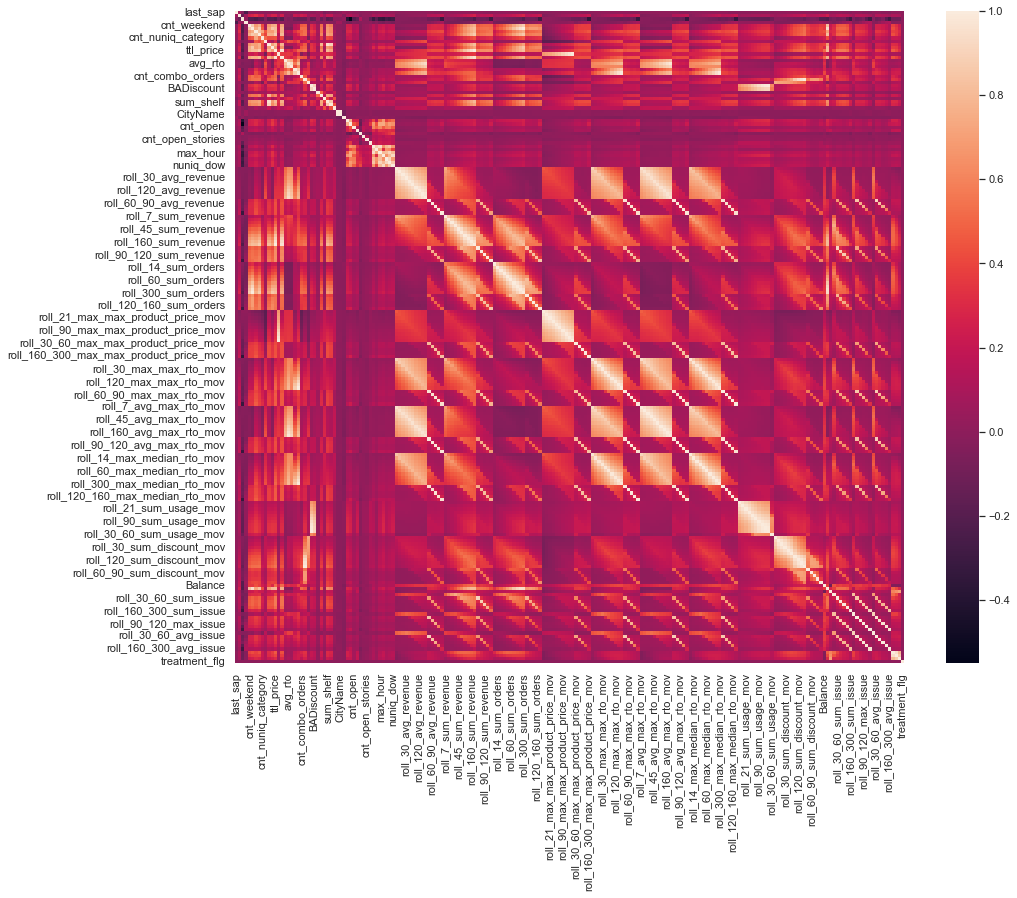

In [36]:
# fastcheck multicollinearity
plt.figure(figsize=(15, 12))
sns.heatmap(features.corr())
plt.show()

Наблюдаем значительное количество скоррелированных признаков. Вероятно, они либо близки по смыслу (считаются из одинаковых/схожих компонент), либо какие-то параметры являются входными для плолучения других (~ roll_n_max_median_rto - roll_n_max_max_rto_mov).  

Визуальный анализ heatmap'a позволяет предположить, что мы можем отсеять половину и более фичей. 

In [37]:
X = num.copy()
y = data['target_7_sum_revenue'][X.index]

In [38]:
treatment_mapping = {
    'control': 0, 
    'p20_999': 1, 
    'p25_999': 2, 
    'p30_999': 3, 
}

treatment = data['treatment'].map(treatment_mapping)[X.index]

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True, stratify=treatment)

##### Catboost 

In [40]:
# BADiscount could also be categorical 
# but it contains 2k+ unique values, for now let's consider it continious 
categorical_features =['CityName', 'RegionName', 'name', 'usage', 'Version'] 
categorical_features_idx = [X.columns.get_loc(f) for f in categorical_features]

In [41]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features_idx) 
test_pool = Pool(X_val, y_val, cat_features=categorical_features_idx)

In [42]:
def select_features_with_catboost(train_pool, test_pool, num_features_to_select): 
    categorical_features =['CityName', 'RegionName', 'name'] 
    catboost = CatBoostRegressor(iterations=2000, random_state=42, cat_features=categorical_features_idx) 
    res = catboost.select_features(
        train_pool, 
        eval_set=test_pool, 
        features_for_select=list(range(X.shape[1])), 
        num_features_to_select=num_features_to_select, 
        steps=1, 
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, 
        shap_calc_type=EShapCalcType.Regular, 
        train_final_model=False, 
        logging_level='Silent', 
        plot=True 
    )
    return res 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

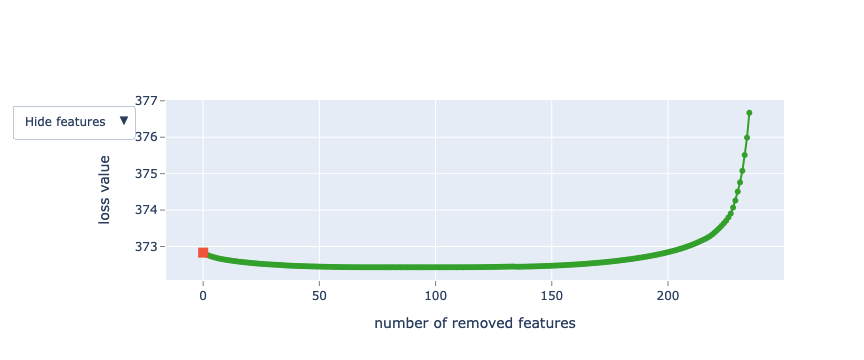

In [43]:
# one feature to select to chech the whole plot
res = select_features_with_catboost(train_pool=train_pool, test_pool=test_pool, num_features_to_select=1)

На графике видим, что возрастание функции потерь начинается после удаления 150 признаков (видно, если увеличить масштаб графика).  
Прим: по графику RMSE наблюдаем переобучение. 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

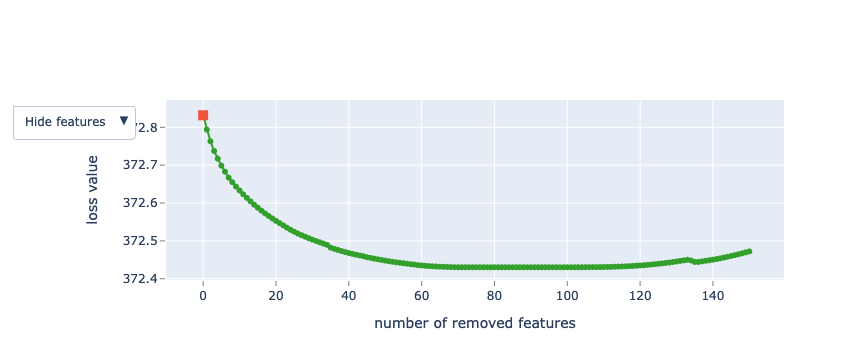

In [44]:
n_features = (X.shape[1]-150)
res = select_features_with_catboost(train_pool=train_pool, test_pool=test_pool, num_features_to_select=n_features)

Видим возрастание функции потерь на графике loss (сотые доли).
Сейчас такая разница кажется незначительной + скорость обучения модели на этапе тестирования вариантов приоритетна. Сейчас нерационально увеличивать количество оставленных признаков, но стоит помнить про такую возможность. 

In [45]:
res['eliminated_features_names']

['roll_60_90_max_issue',
 'roll_60_90_max_max_rto_mov',
 'cnt_loyalty',
 'roll_60_90_avg_issue',
 'roll_60_90_max_median_rto_mov',
 'roll_60_sum_revenue',
 'roll_60_90_sum_discount_mov',
 'roll_30_60_avg_issue',
 'roll_300_avg_revenue',
 'roll_300_avg_max_rto_mov',
 'roll_45_avg_revenue',
 'BADiscount',
 'roll_160_max_max_product_price_mov',
 'roll_120_160_max_redemption',
 'roll_60_avg_max_rto_mov',
 'roll_120_160_avg_redemption',
 'roll_60_90_avg_revenue',
 'roll_90_max_max_product_price_mov',
 'roll_21_sum_revenue',
 'roll_160_300_avg_redemption',
 'avg_discount',
 'roll_90_120_max_max_rto_mov',
 'roll_120_avg_revenue',
 'roll_30_sum_revenue',
 'roll_7_avg_max_rto_mov',
 'roll_0_30_avg_redemption',
 'cnt_nuniq_category',
 'roll_160_300_max_issue',
 'roll_14_avg_revenue',
 'max_product_price',
 'roll_30_60_sum_discount_mov',
 'roll_120_160_sum_redemption',
 'roll_90_120_sum_redemption',
 'roll_45_max_max_rto_mov',
 'avg_products_on_order',
 'RegionName',
 'roll_0_30_sum_issue',
 'rol

In [46]:
# fm feature - ? all available user margin? 
res['selected_features_names']

['nuniq_sap',
 'last_dt',
 'lifetime',
 'cnt_nuniq_products',
 'cnt_mobile_orders',
 'ttl_price',
 'fm',
 'avg_fm',
 'avg_rto',
 'median_rto',
 'all_discount',
 'sum_waiting',
 'sum_trip',
 'avg_trip',
 'name',
 'CityName',
 'cnt_event',
 'cnt_nuniq_event',
 'cnt_open',
 'cnt_push_click',
 'cnt_open_stories',
 'avg_hour',
 'max_hour',
 'nuniq_hour',
 'avg_dow',
 'nuniq_dow',
 'roll_21_avg_revenue',
 'roll_60_avg_revenue',
 'roll_160_avg_revenue',
 'roll_30_60_avg_revenue',
 'roll_90_120_avg_revenue',
 'roll_120_160_avg_revenue',
 'roll_160_300_avg_revenue',
 'roll_45_sum_revenue',
 'roll_160_sum_revenue',
 'roll_300_sum_revenue',
 'roll_90_120_sum_revenue',
 'roll_160_300_sum_revenue',
 'roll_45_sum_orders',
 'roll_120_sum_orders',
 'roll_90_120_sum_orders',
 'roll_300_max_max_product_price_mov',
 'roll_30_60_max_max_product_price_mov',
 'roll_90_120_max_max_product_price_mov',
 'roll_120_160_max_max_product_price_mov',
 'roll_160_300_max_max_product_price_mov',
 'roll_21_max_max_rto_m

In [47]:
train_features = res['selected_features_names']

Используем для обучения фичи, выбранные катбустом. 

# Обучение моделей 

Необходимо решить задачу uplift modeling with multiple treatment.  
Источники: 
- [Библиотека для uplift-моделирования с множественным treatment](https://towardsdatascience.com/mr-uplift-multiple-responses-in-uplift-models-59a88de57e35)
- Возможный [подход к оценке модели](https://medium.com/building-ibotta/erupt-expected-response-under-proposed-treatments-ff7dd45c84b4)

* X - user features 
* y - target (revenue for our case)
* t - treatment 


Планировалось использовать библиотеку MRUplift, представленную в обеих ссылках, но возникли проблемы с ее установкой. 
Также рассматривалась библиотека [scikit-uplift](https://www.uplift-modeling.com/en/latest/), но по каким-то причинам она поддерживает только бинарный таргет. 

Принцип моделирования, тем не менее, понятен. Для определения наилучшего предложения необходимо каждого клиента из валидационной выборки проскорить с n-ным значением treatment, затем сравнить с КГ, и выбрать treatment, где uplift максимален. Для упрощения процесса можем выбирать treatment с максимальным таргетом, и затем считать uplift. 

В библиотеке MR-Uplift предлагается использовать нейросеть в качестве основной модели. Потенциально это может быть хорошим решением, т.к. мы имеем данные с большим количеством признаков => большим количеством нелинейных зависимостей с таргетом и другими признаками. Однако, у меня не получилось быстро установить tensorflow на М1:) По этой же причине в ноутбуке не используется библиотека MR-uplift из ссылок выше. 


In [49]:
X_train = X_train[train_features].join(treatment)
X_val = X_val[train_features].join(treatment)

In [50]:
train_pool = Pool(X_train, y_train)

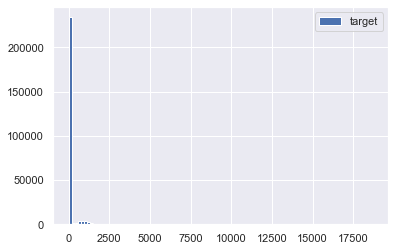

In [51]:
plt.hist(train_pool.get_label(), bins=100, label='target'); plt.legend(); plt.show()

In [52]:
sm_params = {"iterations": 1000,
             "loss_function": "RMSE",
             "random_state": 42, 
             "verbose": 500}

sm_scores = cv(
    train_pool,
    sm_params,
    fold_count=3, 
    plot="True"
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 386.0186060	test: 385.9904933	best: 385.9904933 (0)
500:	learn: 362.8809584	test: 372.0579059	best: 371.9778711 (299)
999:	learn: 356.5819004	test: 372.3908889	best: 371.9778711 (299)	total: 57.1s	remaining: 0us


In [53]:
sm_scores['test-RMSE-mean'].sort_values(ascending=True)

299    371.977871
296    371.978813
298    371.978850
295    371.979016
297    371.979369
          ...    
4      383.206206
3      383.834190
2      384.515153
1      385.232972
0      385.990493
Name: test-RMSE-mean, Length: 1000, dtype: float64

Видим, что после 100 итераций модель не улучшается и "застревает" на одном и том же RMSE. 
Скорее всего, это происходит из-за низкой конверсии пользователей => большого количества нулевых значений в данных. 

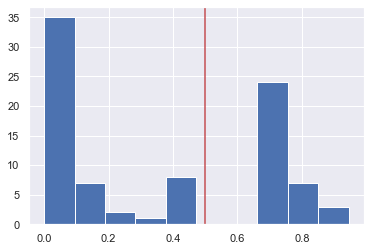

In [54]:
# all features 
zero_frac = (X_train==0).mean()
zero_frac.hist()
plt.axvline(.5, color='r'); plt.show()

In [55]:
zero_frac[zero_frac>0.9]

cnt_redemption              0.944797
roll_0_30_sum_redemption    0.917656
dtype: float64

In [56]:
X_train = X_train[zero_frac[zero_frac<=.9].index]
y_train = y_train[X_train.index]

In [57]:
(y_train == 0).mean()

0.9172045841174552

Все еще присутствует проблема с таргетом - менее 10% данных ненулевые. 
Решить эту проблему можно путем oversampling, downsampling. 

Потенциальное хорошее решение - [SMOGN](https://pypi.org/project/smogn/), необходимо разбираться. 
Быстрое решение - оверсемплинг с добавлением шума в тагрет. 

In [58]:
oversampled = []
for i in range(5): 
    y_sel = y_train[y_train!=0] 
    X_sel = X_train[y_train!=0] 

    noise = np.random.rand(y_sel.shape[0]) 
    noised_target = pd.Series(data=(y_sel.values + noise), index=y_sel.index, name=y_train.name) 

    oversampled.append(X_sel.join(noised_target)) 
    
oversampled = pd.concat(oversampled, axis=0)  

In [59]:
initial = pd.concat([X_train, y_train], axis=1)
train_oversampled = pd.concat([initial, oversampled], axis=0).reset_index(drop=True)
train_oversampled.eval('target_7_sum_revenue!=0').mean()

0.3513299490693274

In [60]:
pool_oversampled = Pool(data=train_oversampled.drop(columns=['target_7_sum_revenue']), 
                        label=train_oversampled['target_7_sum_revenue'] 
                       )

In [61]:
sm_params = {"iterations": 3000,
             "loss_function": "RMSE",
             "random_state": 42, 
             "verbose": 1000}

sm_scores = cv(
    pool_oversampled,
    sm_params,
    fold_count=3, 
    plot="True"
) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 790.8274701	test: 790.8624906	best: 790.8624906 (0)
1000:	learn: 624.6739159	test: 638.1971060	best: 638.1971060 (1000)
2000:	learn: 591.6834178	test: 613.2591294	best: 613.2591294 (2000)
2999:	learn: 565.8555495	test: 593.3542719	best: 593.3542719 (2999)	total: 4m 6s	remaining: 0us


Наблюдаем узкий CI и непрерывное уменьшение RMSE. При обучении модели имеет смысл поднять количество итераций. 

In [62]:
sm_params['iterations'] = 15000
sm_params['verbose'] = False
sm_catboost = CatBoostRegressor(**sm_params).fit(pool_oversampled, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [63]:
pred_train = sm_catboost.predict(X_train)
pred_val = sm_catboost.predict(X_val)

In [64]:
def plot_pred(true, predict, ax=None, figsize=(7, 5)): 
    if not ax: 
        _, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x=true, y=predict, ax=ax, s=12, alpha=.5) 
    ax.set_xlabel('true')
    ax.set_ylabel('predict')
    return ax 

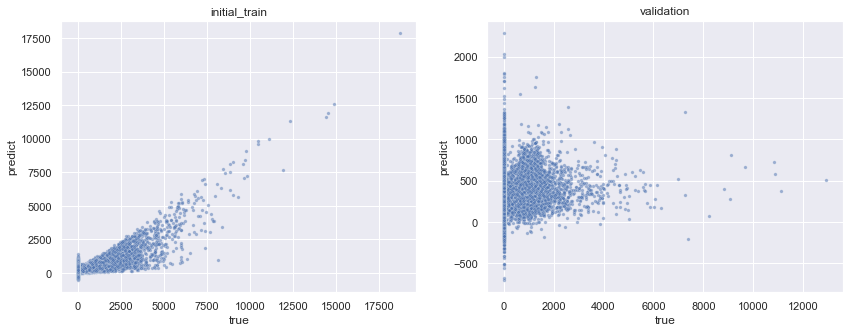

In [65]:
_, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_pred(y_train, pred_train, ax=ax[0]);  ax[0].set_title('initial_train')
plot_pred(y_val, pred_val, ax=ax[1]); ax[1].set_title('validation')
plt.show()

Модель неплохо справляется с обучающей выборкой, но теряет в качестве на валидационной. 
Однако, RMSE стала снижаться при обучении, что свидетельствует о верном направлении подготовки данных. Для улучшения качества модели дальнейшие улучшения: 
- Менее "топорный" oversampling, напр. используя SMOGN
- Подбор гиперпараметров модели  
- Опробовать подход с несколькими моделями - по одной для каждого вида treatment. 

В условиях тестового задания для демонстрации предлагаемого workflow такая модель допустима. 

# Oценка модели 

Для каждого клиента спрогнозируем выручку в зависимости от доступных вариантов treatment, выберем лучший (с максимальной выручкой).  

В реальности необходимо учитывать и затраты на кампанию, т.к. мы наблюдали прямую зависимость между выручкой и размером скидки. В таком случае, самое очевидное решение - предложить максимальные промокоды - это имеет мало общего с реальностью. 

Возможно, стоило предсказывать прибыль - т.к. она уже учитывает затраты на клиента.

In [66]:
synthetic_treats = []
for t in treatment.unique(): 
    tmp = (X_val
           .drop(columns='treatment')
           .copy())
    tmp['treatment'] = t 
    synthetic_treats.append(tmp) 
    

synthetic_treats = (pd.concat(synthetic_treats+[X_val], axis=0)
                    .drop_duplicates()
                    .reset_index())
assert X_val.shape[0]*4 == synthetic_treats.shape[0] 

In [67]:
synthetic_treats['treatment'].unique()

array([2, 1, 3, 0])

In [68]:
# select best offer per user 
synthetic_pred = sm_catboost.predict(synthetic_treats)
synthetic_treats['predict'] = synthetic_pred

In [69]:
synthetic_treats[['index', 'treatment', 'predict']].sort_values('index', ignore_index=True)

index  treatment     predict
0            5          2  264.407553
1            5          1  263.419804
2            5          0  238.523426
3            5          3  280.015066
4           15          3  527.536252
...        ...        ...         ...
254527  321936          3  281.238530
254528  321946          3  122.497281
254529  321946          1   97.406763
254530  321946          0   50.902292
254531  321946          2  113.571297

[254532 rows x 3 columns]

In [70]:
max_rev = pd.DataFrame(synthetic_treats
                       .query('treatment!=0') # probably not necessary in case of a good model 
                       .groupby('index', sort=False)['predict'].max()
                      ).reset_index()

# best offers, no matter what group, usually nonzero
best_offer = synthetic_treats.merge(max_rev, 
                                    how='inner', 
                                    on=['index', 'predict'])[['index', 'treatment', 'predict']]
# if in control, no matter what group
if_no_treat = synthetic_treats.query('treatment==0')[['index', 'treatment', 'predict']].reset_index(drop=True) 

In [71]:
# for each user - best_offer + if control 
show(best_offer)
show(if_no_treat)

index  treatment     predict
0   32486          2  113.884706
1   32801          2  154.420802
2  195533          2  304.141881

Full shape:  (63633, 3)


index  treatment     predict
0  137826          0  204.606933
1  175325          0  205.055368
2  224568          0  363.793744

Full shape:  (63633, 3)


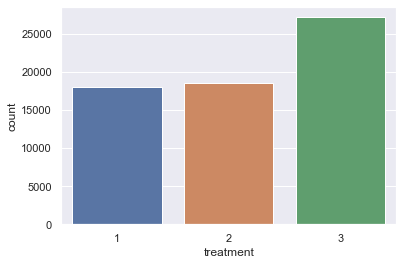

In [72]:
# best offer 0 is probably the result of a poor model quality 
sns.countplot(data=best_offer, x='treatment'); 
plt.show()

Так как мы не знаем, на какой процент выборки необходимо применить кампанию, используем метрику uplift by percentile [источник](https://habr.com/ru/company/ru_mts/blog/538934/). 
- Сортируем по предсказанному значению uplift
- Делим отсортированные данные на перцентили / децили / бины.
- В каждом перцентиле отдельно оцениваем uplift как разность между средними значениями целевой переменной в тестовой и контрольной группах. 

In [73]:
orig = X_val[['treatment']].join(y_val).rename(columns={'treatment':'treatment_orig'}).reset_index()

In [74]:
model_results = pd.merge(left=best_offer.rename(columns={'treatment':'proposed_treatment', 'predict':'predict_best_offer'}), 
                         right=if_no_treat.rename(columns={'predict':'predict_if_cg'}).drop(columns='treatment'), 
                         on='index').merge(orig, on='index')

In [75]:
tmp = model_results.query('treatment_orig==0').copy()
tmp['uplift'] = tmp['predict_best_offer'] - tmp['target_7_sum_revenue']
cg_uplift = tmp[['treatment_orig', 'target_7_sum_revenue', 'uplift']]

In [76]:
tmp = model_results.query('treatment_orig!=0').copy()
tmp['uplift'] = tmp['target_7_sum_revenue'] - tmp['predict_if_cg']
tg_uplift = tmp[['treatment_orig', 'target_7_sum_revenue', 'uplift']]

In [77]:
# our model tends to increase predictions on val data 
show(tg_uplift)

treatment_orig  target_7_sum_revenue       uplift
0               2                   0.0  -101.804115
1               3                2293.0  2127.739847
2               1                   0.0  -308.560228

Full shape:  (57224, 3)


In [78]:
uplifts = pd.concat([tg_uplift, cg_uplift])#; uplifts.shape
uplifts

treatment_orig  target_7_sum_revenue       uplift
0                   2                   0.0  -101.804115
1                   3                2293.0  2127.739847
2                   1                   0.0  -308.560228
3                   1                   0.0  -162.853714
4                   1                   0.0   -91.475209
...               ...                   ...          ...
63600               0                   0.0   234.446043
63603               0                   0.0   343.950326
63611               0                   0.0   220.410798
63624               0                   0.0   447.118554
63625               0                   0.0   610.885830

[63633 rows x 3 columns]

In [79]:
uplifts['bin'] = pd.cut(uplifts['uplift'], bins=10)

In [80]:
uplifts.groupby(['bin', 'treatment_orig']).agg({'uplift':['count', 'std', 'mean'], 
                                        'target_7_sum_revenue':['mean']})

uplift                             \
                                       count          std          mean   
bin                    treatment_orig                                     
(-8400.574, -6300.021] 0                   1          NaN  -8379.776253   
                       1                   0          NaN           NaN   
                       2                   0          NaN           NaN   
                       3                   0          NaN           NaN   
(-6300.021, -4220.266] 0                   4   452.811018  -4891.758977   
                       1                   0          NaN           NaN   
                       2                   0          NaN           NaN   
                       3                   0          NaN           NaN   
(-4220.266, -2140.51]  0                  17   622.832665  -3072.796818   
                       1                   0          NaN           NaN   
                       2                   0          NaN           NaN   
                       3                   1          NaN  -2289.964390   
(-2140.51, -60.755]    0                 413   439.578530   -660.498156   
                       1               17106   153.031515   -299.973192   
                       2               17095   148.033817   -297.685212   
                       3               17013   148.618769   -300.009841   
(-60.755, 2019.0]      0                5974   165.297791    304.783921   
                       1                1881   445.031896    444.221684   
                       2                1925   421.406345    436.057623   
                       3                1956   443.748453    437.884985   
(2019.0, 4098.756]     0                   0          NaN           NaN   
                       1                  71   530.648050   2767.810189   
                       2                  66   544.864134   2709.340467   
                       3                  67   569.026429   2758.313990   
(4098.756, 6178.511]   0                   0          NaN           NaN   
                       1                  11   546.948166   4980.363879   
                       2                  11   538.775457   4981.850079   
                       3                  10   608.730683   4746.295862   
(6178.511, 8258.266]   0                   0          NaN           NaN   
                       1                   1          NaN   8141.576567   
                       2                   0          NaN           NaN   
                       3                   3   489.022094   6843.633850   
(8258.266, 10338.021]  0                   0          NaN           NaN   
                       1                   2  1050.047149   9567.298507   
                       2                   2  1005.705716   9111.780600   
                       3                   1          NaN   9091.689897   
(10338.021, 12417.777] 0                   0          NaN           NaN   
                       1                   1          NaN  12417.776678   
                       2                   1          NaN  10741.494893   
                       3                   0          NaN           NaN   

                                      target_7_sum_revenue  
                                                      mean  
bin                    treatment_orig                       
(-8400.574, -6300.021] 0                       8818.000000  
                       1                               NaN  
                       2                               NaN  
                       3                               NaN  
(-6300.021, -4220.266] 0                       5064.250000  
                       1                               NaN  
                       2                               NaN  
                       3                               NaN  
(-4220.266, -2140.51]  0                       3456.058824  
                       1                               NaN  
                   

# Выводы
Низкое качество модели не позволяет посчитать метрику uplift_by_percentile. 

## Улучшения 
Основная сложность задачи - грамотная предобработка данных.  
Основные сложности данных:
- 200+ признаков и полное отсутствие документации 
- Низкие конверсии, как следствие - множество нулевых значений, в т.ч. в таргетах. 
- Малые эффекты.


Необходимо: 
- Детальнее изучить доступные признаки 
- Попробовать большее количество методов отбора признаков и детекции аномалий, построить пайплайн тестирования 
- Протестировать разные подходы к построению uplift-моделей, различные base estimators, подробнее изучить готовые библиотеки. 
- Грамотно спроектировать обучающую выборку - например, лучше провести oversampling, увеличить количество доступных признаков. 

Литература, которая может пригодиться в решении перечисленных проблем: 
- [uplift modeling for multiple treatments](https://arxiv.org/pdf/1908.05372.pdf)
- [Response transformation and profit decomposition for revenue uplift modeling](https://www.sciencedirect.com/science/article/abs/pii/S0377221719309415)
- [Revenue uplift modelling](file:///Users/ksolod/Downloads/Gubela-2017-RevenueUpliftModeling.pdf)
- [Uplift Modeling for Multiple Treatments with Cost
Optimization](https://arxiv.org/pdf/1908.05372.pdf)
- [Sparse regression for large data sets with outliers](https://www.sciencedirect.com/science/article/pii/S037722172100477X)  

Дополнительные комментарии: 
- В зависимости от специфики бизнеса, полезно учитывать cost каждого из доступных маркетинговых предложений. 
- В данном случае тест был спроектирован так, что фактически речь шла о трех разных кампаниях, при этом размер КГ составлял лишь 10%. Это спорный дизайн теста, допустимый, тем не менее, в условиях оптимизации затрат на МК. Было бы полезно проверить, насколько группы были сопоставимы между собой по таргету до начала МК. Вероятно, это можно сделать и на доступных данных, т.к. они содержат агрегаты за разные периоды времени. 
- Неделя, учитывая специфику данных (низкие конверсии) - может быть слишком малым промежутком времени. 